# Link Analysis

# Table of Content

- [Setup](#setup)
- [Hits](#hits)
- [PageRank](#pagerank)
- [SimRank](#simrank)
- [Result Analysis and Discussion](#result)
- [Computation Performance Analysis](#performance)

---
# <a name='setup'></a> Setup

In [1]:
%matplotlib inline
%load_ext memory_profiler

In [2]:
from collections import namedtuple
from copy import deepcopy
from pprint import PrettyPrinter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
pp = PrettyPrinter(indent=4)

## Load Data

In [4]:
Edge = namedtuple('Edge', ('source', 'dest'))

In [5]:
def load_graph_gen(filename):
    with open(filename, 'r') as input_file:
        for line in input_file:
            source, dest = line.strip().split(',')
            yield Edge(source, dest)

In [6]:
file_name_template = 'dataset/graph_{num}.txt'

graphs = list()
for i in range(1, 7):
    filename = file_name_template.format(num=i)
    graph_gen = load_graph_gen(filename)
    graphs.append(nx.DiGraph(graph_gen))

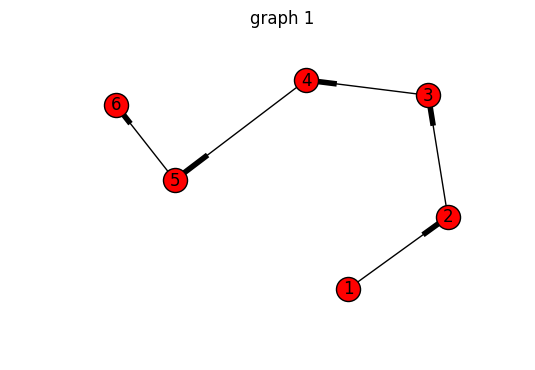

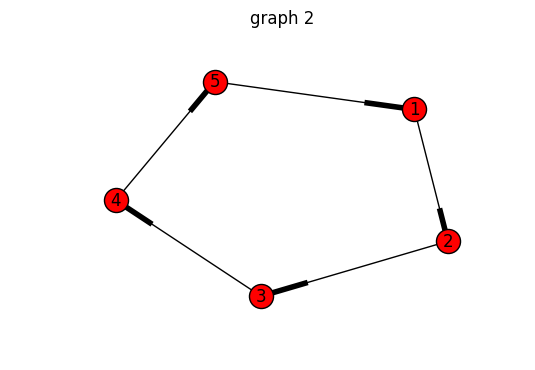

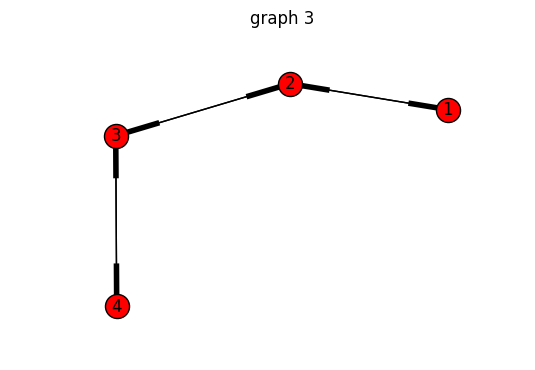

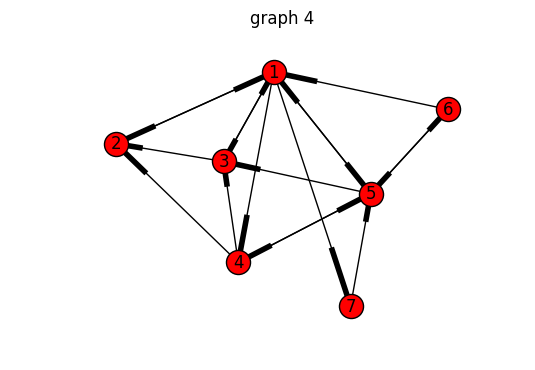

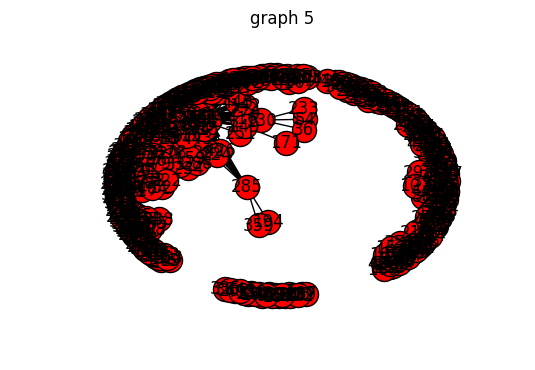

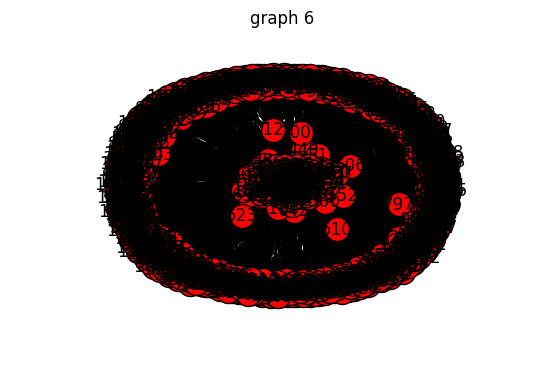

In [7]:
# Visualize  graphs
for index, graph in enumerate(graphs, 1):
    plt.figure(index)
    plt.title('graph {index}'.format(index=index))
    nx.draw(graph, arrows=True, with_labels=True)

---
# <a name='hits'></a> Hits

---
# <a name='pagerank'></a> Page Rank

In [8]:
def pagerank(graph, *, alpha=0.85, episilon=1e-06):
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    out_degs = np.sum(adj_matrix, axis=1)
    damping_factor = 1 - alpha
    
    # Nodes with no outgoing edges
    dangle_nodes = [
        index
        for index, o_deg in enumerate(graph.out_degree().values())
        if not o_deg
    ]
    
    # Page Ranks
    prs = np.array([1/node_num for _ in range(node_num)])
    # Page Ranks in previous iteration
    pre_prs = np.array([0 for _ in range(node_num)])
    
    delta = np.sum(np.abs(prs - pre_prs))
    while delta > episilon:
        pre_prs = deepcopy(prs)
        
        # Page Rank values each node can contribute in each edge
        pr_quotas = np.array(
            [pr/deg if deg else 0 for pr, deg in zip(pre_prs, out_degs)]
        )
        dangle_sum = np.sum([pre_prs[dangle_node]/node_num
                             for dangle_node in dangle_nodes])

        prs = (
            damping_factor / node_num +
            alpha *
            (
                adj_matrix.transpose().dot(pr_quotas[:, np.newaxis]) +
                dangle_sum
            )
        ).flatten()
        
        # Normalize
        prs /= np.sum(prs)
        delta = np.sum(np.abs(prs - pre_prs))
        
    # Mapping node name to its page rank
    prs_mappping = {node: pr for node, pr in zip(graph.nodes(), prs)}
    return prs_mappping

### Reference 
[PageRank Lecture Note](http://www.ccs.northeastern.edu/home/daikeshi/notes/PageRank.pdf)

---
# <a name='simrank'></a> SimRank

In [9]:
np.seterr(divide='ignore', invalid='ignore')

def simrank(graph, *, C=0.8, epsilon=1e-06):
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    adj_matrix /= np.sum(adj_matrix, axis=0)
    adj_matrix = np.nan_to_num(adj_matrix)
    
    pre_sim = np.zeros(node_num)
    sim = np.eye(node_num)
    delta = np.sum(np.abs(sim - pre_sim))
    while delta > epsilon:
        pre_sim = deepcopy(sim)
        sim = C * adj_matrix.transpose().dot(pre_sim).dot(adj_matrix)
        for i in range(node_num):
            sim[i, i] = 1
        delta = np.sum(np.abs(sim - pre_sim))
    return sim

---

# <a name='result'></a> Result Analysis and Discussion

## Hits

## Page Rank

In [10]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(pagerank(graph))


Graph 1
{   '1': 0.060716150359376504,
    '2': 0.1123249278306801,
    '3': 0.15619235710247792,
    '4': 0.1934794507762447,
    '5': 0.22517347758916137,
    '6': 0.25211363634205952}

Graph 2
{   '1': 0.20000000000000001,
    '2': 0.20000000000000001,
    '3': 0.20000000000000001,
    '4': 0.20000000000000001,
    '5': 0.20000000000000001}

Graph 3
{   '1': 0.17543856058862933,
    '2': 0.32456143941137072,
    '3': 0.32456143941137072,
    '4': 0.17543856058862933}

Graph 4
{   '1': 0.2802878551778531,
    '2': 0.15876446265602656,
    '3': 0.13888181220259527,
    '4': 0.10821960072742001,
    '5': 0.18419809708011373,
    '6': 0.060570694570464538,
    '7': 0.069077477585526917}

Graph 5
{   '1': 0.0016219554229487472,
    '10': 0.0019564189877011311,
    '100': 0.0017232887848194483,
    '101': 0.0016785662685149874,
    '102': 0.0016803290881002638,
    '103': 0.0017137749250352994,
    '104': 0.0099378200191001815,
    '105': 0.0026171389802050991,
    '106': 0.0019656333783

## Sim Rank

In [11]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(simrank(graph))


Graph 1
array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

Graph 2
array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

Graph 3
array([[ 1.        ,  0.        ,  0.66666655,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.66666655],
       [ 0.66666655,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.66666655,  0.        ,  1.        ]])

Graph 4
array([[ 1.        ,  0.3426946 ,  0.53506349,  0.36974703,  0.53506349,
         0.44956621,  0.35373453],
       [ 0.3426946 ,  1.        ,  0.27314849,  0.41218164,  0.4122407 ,
         0.39005383,  0.33765876],
       [ 0.53506349,  0.27314849,  1.        ,  0.2854419 ,  0.27012699,
         0.44809422,  0.

# <a name='performance'></a> Computation Performance Analysis

## Time

### Hits

### Page Rank

In [12]:
%%time

for graph in graphs:
    pagerank(graph)

CPU times: user 62.7 ms, sys: 13.2 ms, total: 75.9 ms
Wall time: 67.5 ms


In [13]:
%%time

for graph in graphs:
    nx.pagerank(graph, alpha=0.85)

CPU times: user 77.5 ms, sys: 2.92 ms, total: 80.4 ms
Wall time: 81.7 ms


### SimRank

In [14]:
%%time

for graph in graphs:
    simrank(graph)

CPU times: user 48.3 s, sys: 1.93 s, total: 50.2 s
Wall time: 20 s


## Memory

### Hits

### Page Rank

In [16]:
%%memit

for graph in graphs:
    pagerank(graph)

peak memory: 136.71 MiB, increment: 23.95 MiB


In [17]:
%%memit

for graph in graphs:
    nx.pagerank(graph, alpha=0.85)

peak memory: 137.86 MiB, increment: 1.35 MiB


###  SimRank

In [18]:
%%memit

for graph in graphs:
    simrank(graph)

peak memory: 177.29 MiB, increment: 39.43 MiB
